# Extend Trend Following Strategy ML research (added sample weights, Purged CV, feature importance)

This notebook extends Trend-Following notebook from Chapter3 by adding sample weights, Purged Cross-Validation, MDI, MDA, SFI feature importance plots

In [36]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [37]:
import numpy as np
import pandas as pd
#import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from mlfinlab.feature_importance import (mean_decrease_impurity as feature_importance_mean_decrease_impurity, 
                                        mean_decrease_accuracy as feature_importance_mean_decrease_accuracy, 
                                        single_feature_importance as feature_importance_sfi, plot_feature_importance)
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [38]:
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [39]:
data = data['2011-09-01':]

---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [40]:
# compute moving averages
fast_window = 20
slow_window = 50

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
data.head()

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg'] 
short_signals = data['fast_mavg'] < data['slow_mavg'] 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

In [41]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [42]:
data['side'].value_counts()

 1.0    12333
-1.0    11696
Name: side, dtype: int64

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [43]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [44]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

2023-06-10 09:50:44.834504 100.0% apply_pt_sl_on_t1 done after 0.06 minutes. Remaining 0.0 minutes..


In [45]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

-1.0    1224
 1.0    1120
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [46]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1409
           1       0.40      1.00      0.57       935

    accuracy                           0.40      2344
   macro avg       0.20      0.50      0.29      2344
weighted avg       0.16      0.40      0.23      2344

Confusion Matrix
[[   0 1409]
 [   0  935]]

Accuracy
0.3988907849829352


**A few takeaways**
* There is an imbalance in the classes - more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [47]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478,NaN,NaN,NaN
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,NaN,NaN,NaN
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152,NaN,NaN,NaN
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502,NaN,NaN,NaN
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,NaN,NaN,NaN


### Features

In [48]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [49]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [50]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [51]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [52]:
y.value_counts()

0    1409
1     935
Name: bin, dtype: int64

In [53]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

# Sample weights

In [54]:
return_based_sample_weights = get_weights_by_return(triple_barrier_events.loc[X_train.index], data.loc[X_train.index, 'close'])
time_based_sample_weights = get_weights_by_time_decay(triple_barrier_events.loc[X_train.index], data.loc[X_train.index, 'close'], decay=0.5)

2023-06-10 09:51:20.098112 100.0% num_concurrent_events done after 0.06 minutes. Remaining 0.0 minutes.
2023-06-10 09:51:24.572597 100.0% _apply_weight_by_return done after 0.06 minutes. Remaining 0.0 minutes.
2023-06-10 09:51:28.601704 100.0% num_concurrent_events done after 0.06 minutes. Remaining 0.0 minutes.
2023-06-10 09:51:32.380411 100.0% _get_average_uniqueness done after 0.05 minutes. Remaining 0.0 minutes.


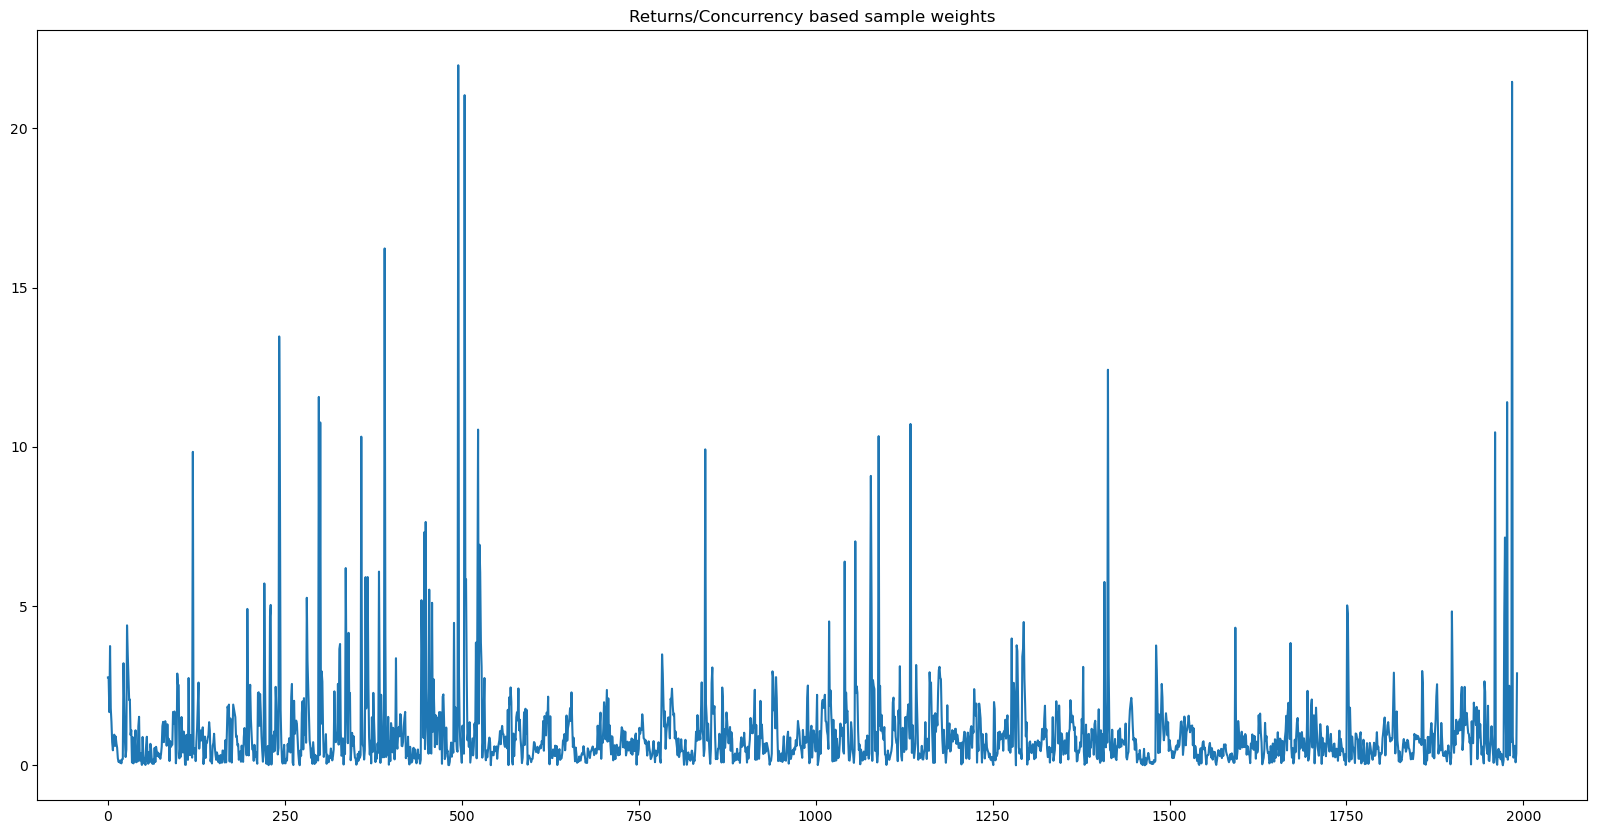

In [55]:
plt.figure(figsize=(20,10))
plt.title('Returns/Concurrency based sample weights')
return_based_sample_weights.reset_index()[0].plot()
plt.show()

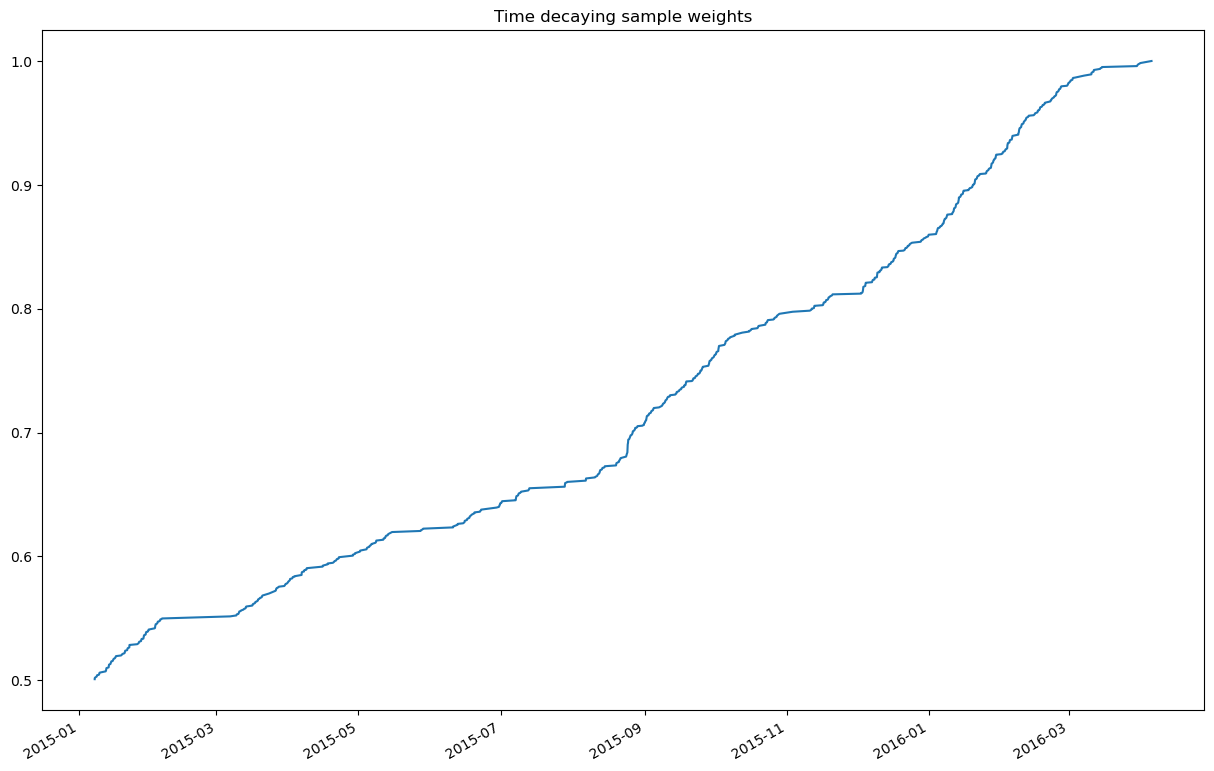

In [56]:
plt.figure(figsize=(15, 10))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

### Cross-Validation

In [57]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

In [58]:
cv_gen_standard = KFold(4)
cv_gen_purged = ml.cross_validation.PurgedKFold(n_splits=4, 
                                                samples_info_sets=triple_barrier_events.loc[X_train.index].t1)

In [59]:
def perform_grid_search(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=triple_barrier_events.loc[X_train.index].t1,
                                                                price_bars = data.loc[X_train.index.min():X_train.index.max(), 'close'],
                                                                n_estimators=n_est, base_estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml.cross_validation.ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring=scoring)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [60]:
def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=triple_barrier_events.loc[X_train.index].t1,
                                                                price_bars = data.loc[X_train.index.min():X_train.index.max(), 'close'],
                                                                n_estimators=n_est, base_estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml.cross_validation.ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring=scoring,
                                                                sample_weight_train=return_based_sample_weights.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [61]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, scoring=f1_score, type = 'standard')

0.3987849929268543
0.40866566958718986
0.4138263091601206
0.41391720448311375
0.4182510028122685


In [62]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, scoring=f1_score, type = 'standard')

0.4686194322546089
0.47163655186837816
0.47980889338756616
0.4799820030016192


In [63]:
top_model

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=3,
                                                        random_state=42),
                  n_jobs=-1, random_state=42)

As you can see adding sample weights increases cross-validation score

# Feature importance

In [64]:
# MDI, MDA, SFI feature importance
mdi_feat_imp = feature_importance_mean_decrease_impurity(top_model, X_train.columns)
mda_feat_imp = feature_importance_mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring=f1_score, 
                                                     sample_weight_train=return_based_sample_weights.values)
sfi_feat_imp = feature_importance_sfi(top_model, X_train, y_train, cv_gen_purged, scoring=f1_score,
                                     sample_weight_train=return_based_sample_weights.values)

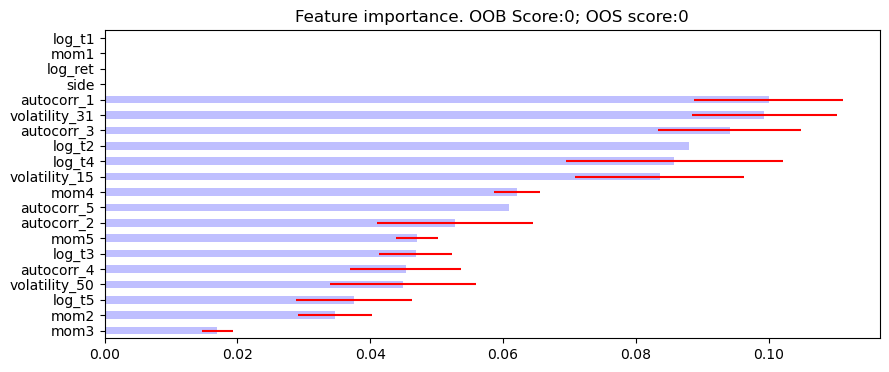

In [65]:
plot_feature_importance(mdi_feat_imp, 0, 0)

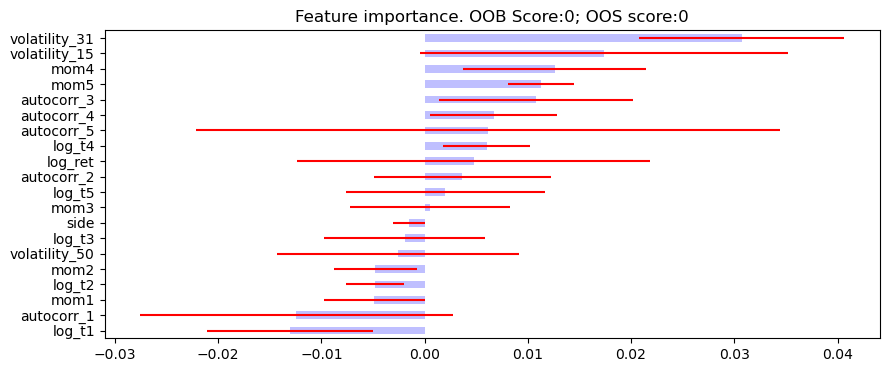

In [66]:
plot_feature_importance(mda_feat_imp, 0, 0)

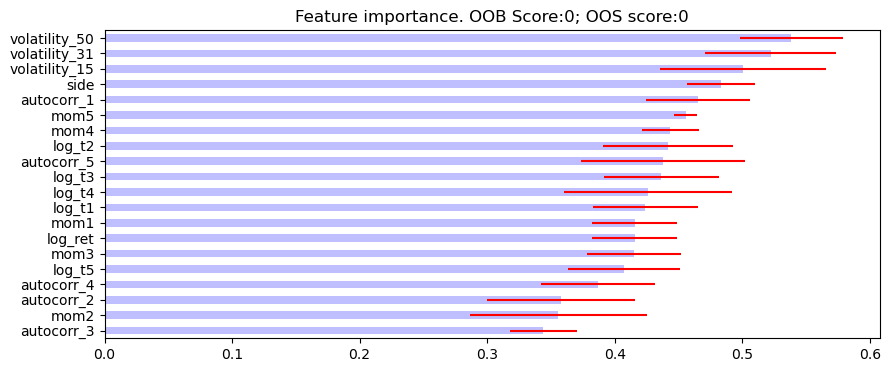

In [67]:
plot_feature_importance(sfi_feat_imp, 0, 0)